In [1]:
import gym
import gym_digger
import numpy as np
import random
from gym import envs
from IPython.display import clear_output
import time
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from IPython import display
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12, 8

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
env = gym.make('DiggerDiscrete-v0')

In [3]:
class Agent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        print('Action size:', self.action_size)
        
    def get_action(self):
        return random.choice(range(self.action_size))

In [4]:
class QNAgent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.n
        print('State size:', self.state_size)
        
        self.epsilon = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def build_model(self):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.int32, shape=[1])
        self.action_in = tf.placeholder(tf.int32, shape=[1])
        self.target_in = tf.placeholder(tf.float32, shape=[1])
        
        self.state = tf.one_hot(self.state_in, depth=self.state_size)
        self.action = tf.one_hot(self.action_in, depth=self.action_size)
        
        self.q_state = tf.layers.dense(self.state, units=self.action_size, name='q_table')
        self.q_action = tf.reduce_sum(tf.multiply(self.q_state, self.action), axis=1)
        
        self.loss = tf.reduce_sum(tf.square(self.target_in - self.q_action))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def get_action(self, state):
        q_state = self.sess.run(self.q_state, feed_dict={self.state_in: [state]})
        action_greedy = np.argmax(q_state)
        action_random = super().get_action()
        return action_random if random.random() < self.epsilon else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = ([exp] for exp in experience)
        
        q_next = self.sess.run(self.q_state, feed_dict={self.state_in: next_state})
        q_next[done] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next)
        
        feed = {self.state_in: state, self.action_in: action, self.target_in: q_target}
        self.sess.run(self.optimizer, feed_dict=feed)
        
        if experience[4]:
            self.epsilon = self.epsilon * 0.99
            
    def __del__(self):
        self.sess.close()
        
agent = QNAgent(env)

Action size: 5
State size: 64


/Volumes/CJH_DATA/anaconda3/envs/gym/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Volumes/CJH_DATA/anaconda3/envs/gym/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Episode: 0, Total reward: -2, Steps: 52, epsilon: 0.99
Episode: 1, Total reward: 2, Steps: 11, epsilon: 0.98
Episode: 2, Total reward: 6, Steps: 13, epsilon: 0.97
Episode: 3, Total reward: -5, Steps: 95, epsilon: 0.96
Episode: 4, Total reward: -6, Steps: 41, epsilon: 0.95
Episode: 5, Total reward: -7, Steps: 38, epsilon: 0.94
Episode: 6, Total reward: -5, Steps: 23, epsilon: 0.93
Episode: 7, Total reward: -4, Steps: 72, epsilon: 0.92
Episode: 8, Total reward: -18, Steps: 98, epsilon: 0.91
Episode: 9, Total reward: -27, Steps: 89, epsilon: 0.90
Episode: 10, Total reward: -37, Steps: 81, epsilon: 0.90
Episode: 11, Total reward: -37, Steps: 26, epsilon: 0.89
Episode: 12, Total reward: -39, Steps: 50, epsilon: 0.88
Episode: 13, Total reward: -39, Steps: 32, epsilon: 0.87
Episode: 14, Total reward: -36, Steps: 15, epsilon: 0.86
Episode: 15, Total reward: -40, Steps: 72, epsilon: 0.85
Episode: 16, Total reward: -46, Steps: 87, epsilon: 0.84
Episode: 17, Total reward: -49, Steps: 57, epsilon:

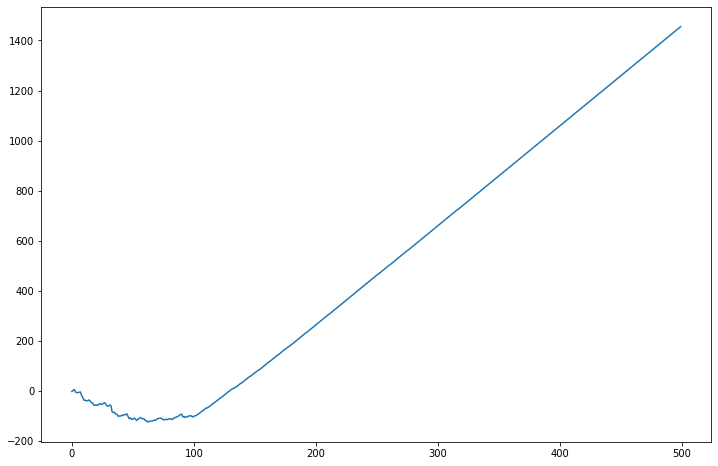

In [5]:
# training
total_reward = 0
all_rewards = []
for episode in range(500):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        steps += 1
        agent.train((state, action, next_state, reward, done))
        state = next_state
        total_reward += reward
        
#         print('s:', state, 'a:', action)
#         print('Episode: {}, Total reward: {}, Steps: {}, epsilon: {:.2f}'.format(episode, total_reward, steps, agent.epsilon))
#         env.render()
        with tf.variable_scope('q_table', reuse=True):
            weights = agent.sess.run(tf.get_variable('kernel'))  
#             print(weights)
#         time.sleep(0.25)
#         clear_output(wait=True)
    print('Episode: {}, Total reward: {}, Steps: {}, epsilon: {:.2f}'.format(episode, total_reward, steps, agent.epsilon))
    all_rewards.append(total_reward)
plt.plot(all_rewards)

In [6]:
# testing
total_reward = 0
agent.epsilon = 0
for episode in range(10):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        # update
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        steps += 1
        state = next_state
        total_reward += reward
        
        # output
        print('s:', state, 'a:', action)
        print('Episode: {}, Total reward: {}, Steps: {}, epsilon: {:.2f}'.format(episode, total_reward, steps, agent.epsilon))
        env.render()
        time.sleep(0.2)
        clear_output(wait=True)

s: 61 a: 4
Episode: 9, Total reward: 40, Steps: 7, epsilon: 0.00
  (Dig)
00
00
